## **Importing Libraries**


In [1]:
import zipfile
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

## **Connecting Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Uploading Data**

In [3]:
!unzip /content/drive/MyDrive/skin_disease_dataset.zip -d /content/

Archive:  /content/drive/MyDrive/skin_disease_dataset.zip
replace /content/Split_smol/train/Actinic keratosis/ISIC_0024468.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace /content/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Split_smol/train/Actinic keratosis/ISIC_0024707.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Train-Test Split**

In [7]:
train_dir = '/content/Split_smol/train'
val_dir = '/content/Split_smol/val'

train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)

print("Training Classes:", train_classes)
print("Validation Classes:", val_classes)


Training Classes: ['Tinea Ringworm Candidiasis', 'Melanoma', 'Dermatofibroma', 'Vascular lesion', 'Atopic Dermatitis', 'Squamous cell carcinoma', 'Actinic keratosis', 'Melanocytic nevus', 'Benign keratosis']
Validation Classes: ['Tinea Ringworm Candidiasis', 'Melanoma', 'Dermatofibroma', 'Vascular lesion', 'Atopic Dermatitis', 'Squamous cell carcinoma', 'Actinic keratosis', 'Melanocytic nevus', 'Benign keratosis']


## **Display random resized images with disease names**


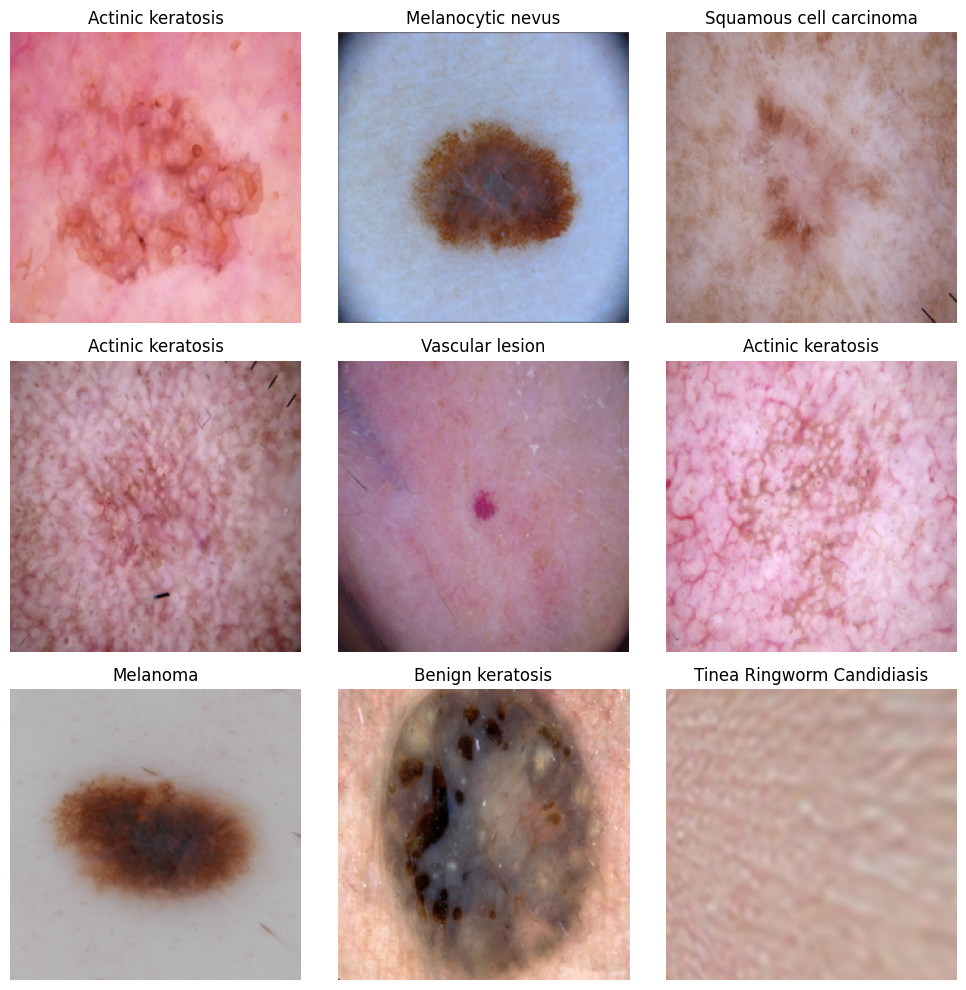

In [8]:
def display_random_images_with_disease(resized_images, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img, img_path = random.choice(resized_images)

        disease_name = os.path.basename(os.path.dirname(img_path))

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(disease_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

resized_images = []
desired_size = (224, 224)

image_files = []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))
for root, _, files in os.walk(val_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

for img_path in image_files:
    try:
        img = Image.open(img_path)
        img_resized = img.resize(desired_size)
        resized_images.append((img_resized, img_path))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

display_random_images_with_disease(resized_images)

## **Check Image Properties (Size, Format, Mode)**


In [9]:
def check_image_properties(image_path):
    img = Image.open(image_path)
    print(f"Image size: {img.size}")
    print(f"Format: {img.format}")
    print(f"Mode: {img.mode}")


for i in range(9):
    check_image_properties(image_files[i])

Image size: (615, 578)
Format: JPEG
Mode: RGB
Image size: (72, 137)
Format: PNG
Mode: RGB
Image size: (358, 434)
Format: JPEG
Mode: RGB
Image size: (277, 293)
Format: PNG
Mode: RGB
Image size: (740, 630)
Format: PNG
Mode: RGB
Image size: (738, 517)
Format: PNG
Mode: RGB
Image size: (270, 210)
Format: JPEG
Mode: RGB
Image size: (300, 249)
Format: JPEG
Mode: RGB
Image size: (300, 213)
Format: JPEG
Mode: RGB


## **Data Summary for Train and Validation Sets**


In [10]:
train_dir = '/content/Split_smol/train'
val_dir = '/content/Split_smol/val'

def get_data_summary(directory):
    class_summary = {}
    for cls in os.listdir(directory):
        class_dir = os.path.join(directory, cls)
        if os.path.isdir(class_dir):
            num_images = len([img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])
            class_summary[cls] = num_images
    return class_summary

train_summary = get_data_summary(train_dir)
val_summary = get_data_summary(val_dir)

def print_data_summary(summary, dataset_name):
    print(f"{dataset_name} Data Summary:")
    for cls, count in summary.items():
        print(f"Class '{cls}': {count} images")

print_data_summary(train_summary, "Train")
print_data_summary(val_summary, "Validation")

Train Data Summary:
Class 'Tinea Ringworm Candidiasis': 56 images
Class 'Melanoma': 80 images
Class 'Dermatofibroma': 80 images
Class 'Vascular lesion': 80 images
Class 'Atopic Dermatitis': 81 images
Class 'Squamous cell carcinoma': 80 images
Class 'Actinic keratosis': 80 images
Class 'Melanocytic nevus': 80 images
Class 'Benign keratosis': 80 images
Validation Data Summary:
Class 'Tinea Ringworm Candidiasis': 20 images
Class 'Melanoma': 20 images
Class 'Dermatofibroma': 20 images
Class 'Vascular lesion': 20 images
Class 'Atopic Dermatitis': 21 images
Class 'Squamous cell carcinoma': 20 images
Class 'Actinic keratosis': 20 images
Class 'Melanocytic nevus': 20 images
Class 'Benign keratosis': 20 images


## **Visualize Class Distribution**


<ipython-input-11-b5a29defde95>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_summary.keys()), y=list(class_summary.values()), palette='viridis')


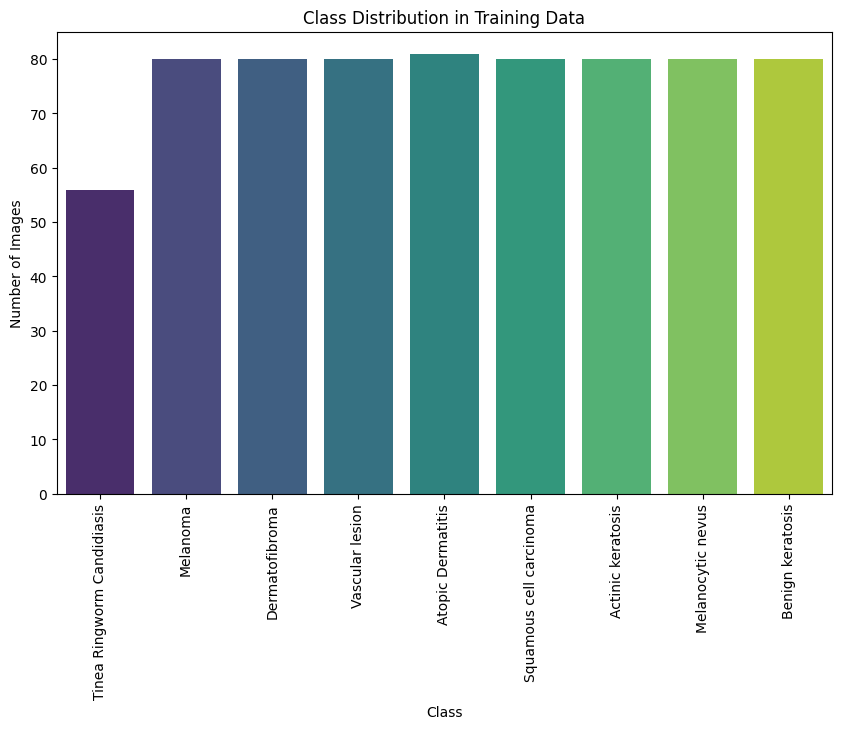

<ipython-input-11-b5a29defde95>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_summary.keys()), y=list(class_summary.values()), palette='viridis')


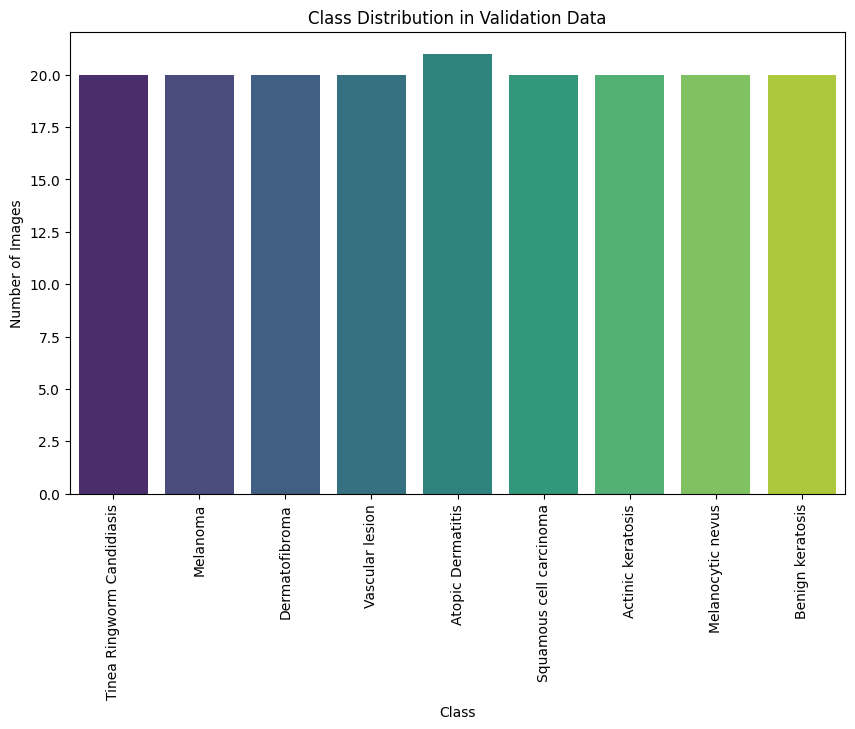

In [11]:
def plot_class_distribution(class_summary, title):
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(class_summary.keys()), y=list(class_summary.values()), palette='viridis')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

plot_class_distribution(train_summary, "Class Distribution in Training Data")
plot_class_distribution(val_summary, "Class Distribution in Validation Data")

## **Printing Sample Images of Train & Test Sets**

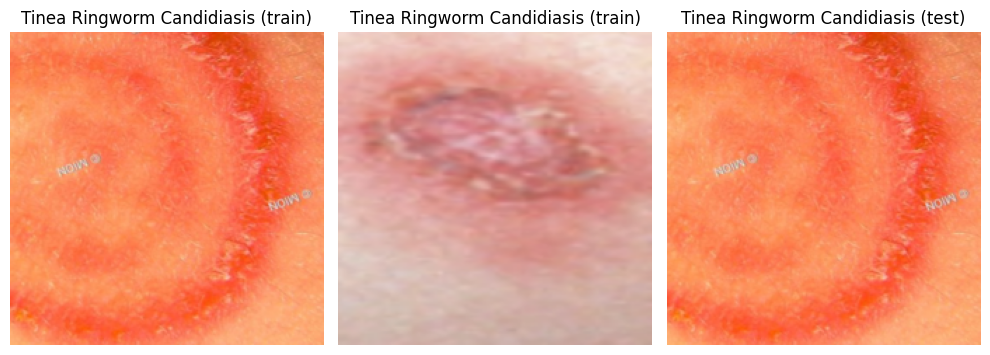

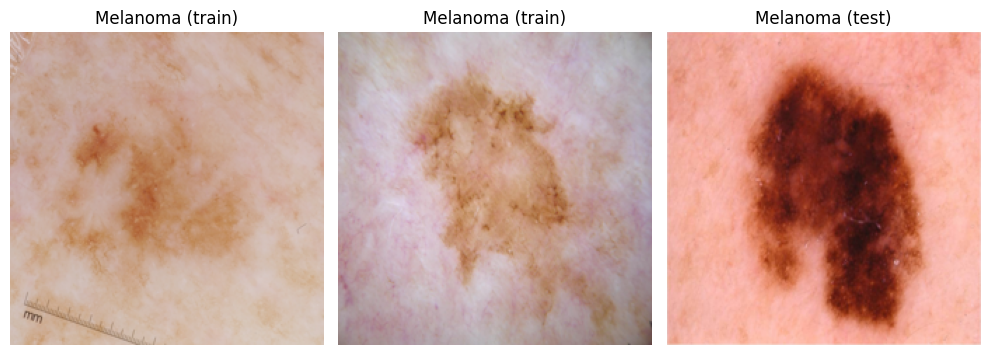

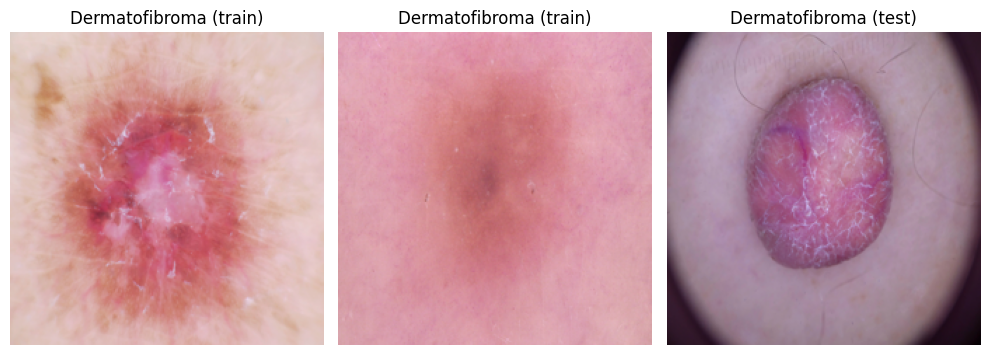

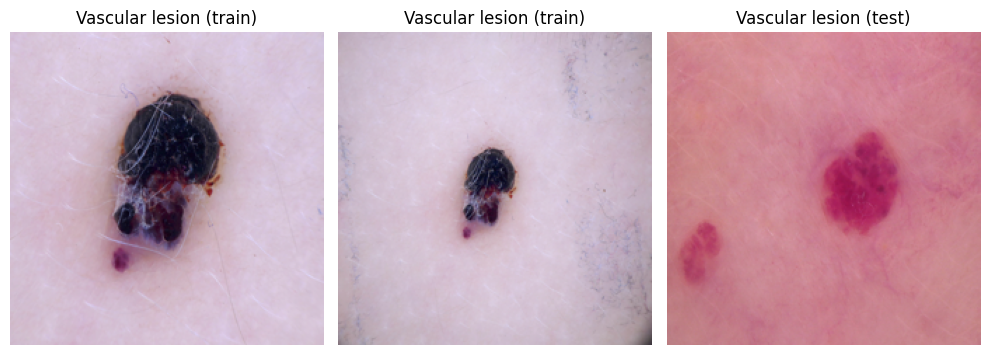

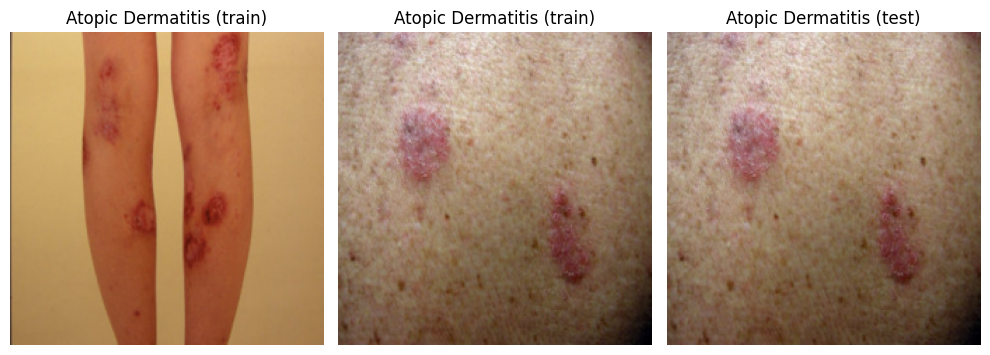

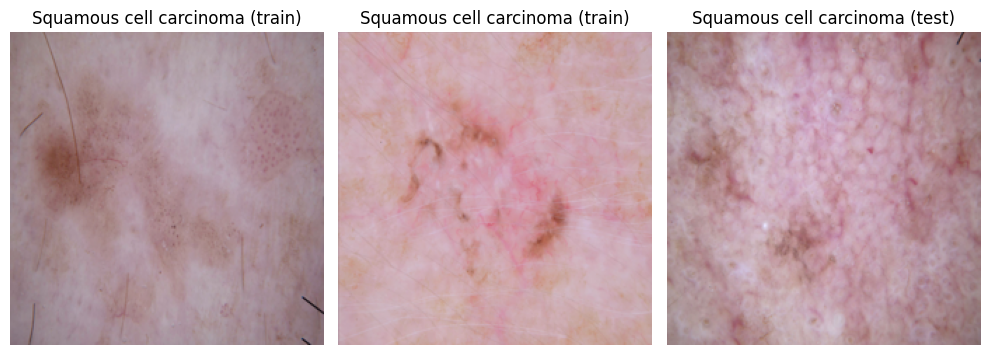

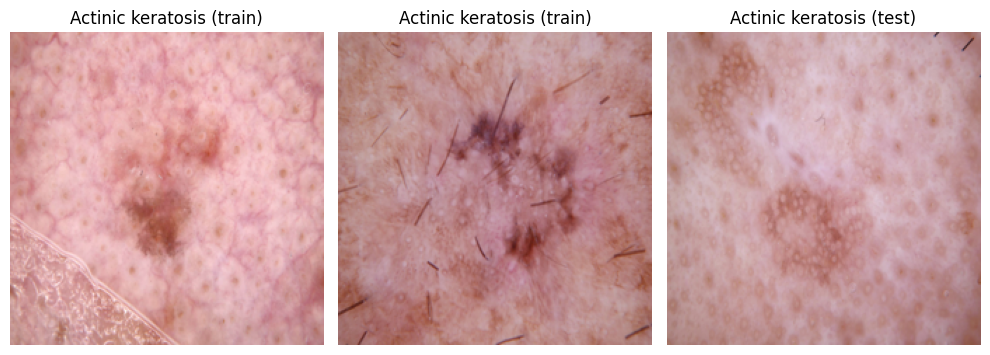

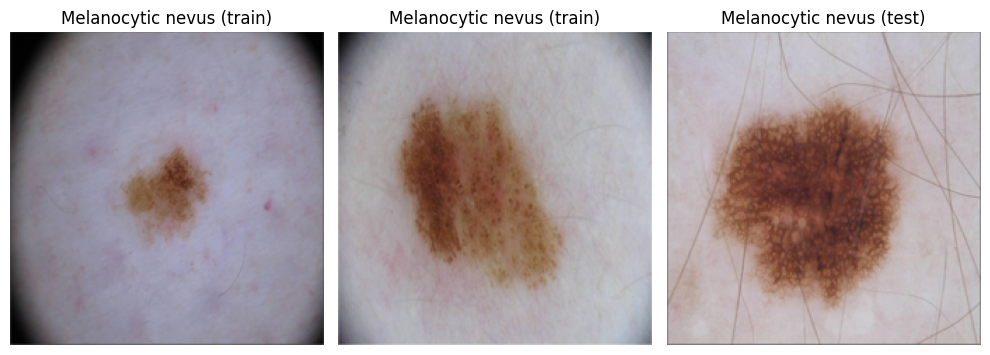

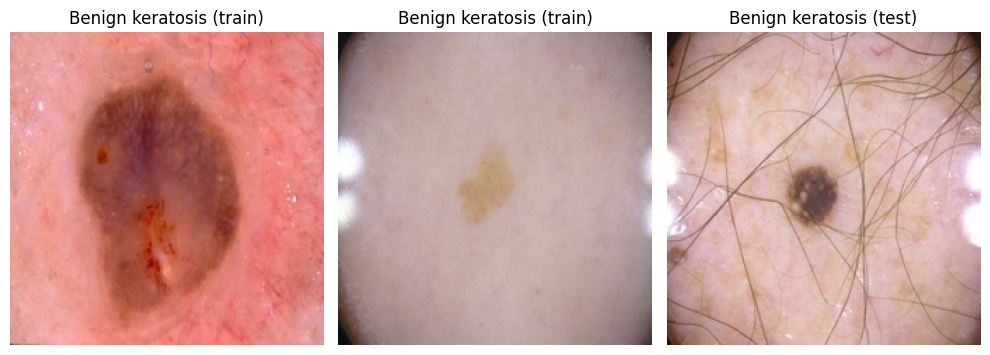

In [12]:
def display_images_per_disease_resized(train_dir, val_dir, desired_size=(224, 224)):
    """
    Displays resized images per disease from train and validation directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        desired_size (tuple): The desired size for resizing images (width, height).
    """
    diseases = os.listdir(train_dir)
    for disease in diseases:
        train_images = [
            os.path.join(train_dir, disease, img)
            for img in os.listdir(os.path.join(train_dir, disease))
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        val_images = [
            os.path.join(val_dir, disease, img)
            for img in os.listdir(os.path.join(val_dir, disease))
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        plt.figure(figsize=(10, 5))

        for i in range(min(2, len(train_images))):
            img_path = train_images[i]
            try:
                img = Image.open(img_path)
                img_resized = img.resize(desired_size)

                plt.subplot(1, 3, i + 1)
                plt.imshow(img_resized)
                plt.title(f"{disease} (train)")
                plt.axis("off")
            except Exception as e:
                print(f"Error loading or displaying image {img_path}: {e}")

        if val_images:
            try:
                # Open and resize the image using PIL
                img_path = val_images[0]
                img = Image.open(img_path)
                img_resized = img.resize(desired_size)

                plt.subplot(1, 3, 3)
                plt.imshow(img_resized)  # Display the resized image
                plt.title(f"{disease} (test)")
                plt.axis("off")
            except Exception as e:
                print(f"Error loading or displaying image {img_path}: {e}")
        plt.tight_layout()
        plt.show()

display_images_per_disease_resized(train_dir, val_dir)

## **Resizing Images**

In [13]:
desired_size = (224, 224)

def resize_images(image_files, desired_size):
    for img_path in image_files:
        try:
          img = Image.open(img_path)
          img_resized = img.resize(desired_size)
          print(f"Image Name: {os.path.basename(img_path)}, Dimensions: {img_resized.size}")
        except Exception as e:
          print(f"Error processing {img_path}: {e}")

image_files = []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))
for root, _, files in os.walk(val_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

resize_images(image_files, desired_size)

Image Name: aug_0_pha-259018.jpg, Dimensions: (224, 224)
Image Name: aug_0_Cv-1.png, Dimensions: (224, 224)
Image Name: aug_0_15436_lores.jpg, Dimensions: (224, 224)
Image Name: aug_0_Screenshot 2021-09-14 112600.png, Dimensions: (224, 224)
Image Name: aug_0_Screenshot 2021-09-14 112827.png, Dimensions: (224, 224)
Image Name: aug_0_Screenshot 2021-09-14 112945.png, Dimensions: (224, 224)
Image Name: afp20080515p1415-f2.jpg, Dimensions: (224, 224)
Image Name: aug_0_afp20141115p702-f1.jpg, Dimensions: (224, 224)
Image Name: 300px-Ringworm_on_the_arm,_or_tinea_corporis_due_to_Trichophyton_mentagrophytes_PHIL_2938_lores.jpg, Dimensions: (224, 224)
Image Name: aug_0_Daad-khujli-kya-hai-or-daad-ka-treatment-ilaj-in-Hindi.jpg, Dimensions: (224, 224)
Image Name: aug_0_Ringworm-Titel.jpg, Dimensions: (224, 224)
Image Name: aug_0_Screenshot 2021-09-14 112150.png, Dimensions: (224, 224)
Image Name: aug_0_Screenshot 2021-09-14 112650.png, Dimensions: (224, 224)
Image Name: aug_0_maxresdefault.jpg,

In [14]:
train_dir = '/content/Split_smol/train'
val_dir = '/content/Split_smol/val'

img_height, img_width = 224, 224

## **Data Augmentation for Training Data (Reduced Augmentation)**


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

## **Data Generators with Image Resizing**


In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical'
)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


## **Define CNN Model Function (2 Layers)**

In [ ]:
def create_cnn_model(learning_rate=0.001, dropout_rate=0.5, kernel_size=(3, 3), pooling='max'):
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size, activation='relu', input_shape=(img_height, img_width, 3)))
    if pooling == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(64, kernel_size, activation='relu'))
    if pooling == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    else:
        model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## **Train Function with Early Stopping**


In [ ]:
def model_train(learning_rate=0.001, dropout_rate=0.5, kernel_size=(3, 3), pooling='max', batch_size=32):
    model = create_cnn_model(learning_rate, dropout_rate, kernel_size, pooling)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

    return history.history['val_accuracy'][-1]

## **Hyperparameter Grid**

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate': [0.5, 0.7],
    'batch_size': [32, 64],
    'kernel_size': [(3, 3)],
    'pooling': ['max'],
}

## **Perform Grid Search**


In [ ]:
def grid_search():
    best_acc = 0
    best_params = {}
    for learning_rate in param_grid['learning_rate']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                for kernel_size in param_grid['kernel_size']:
                    for pooling in param_grid['pooling']:
                        accuracy = model_train(learning_rate, dropout_rate, kernel_size, pooling, batch_size)
                        print(f"Testing lr={learning_rate}, dropout={dropout_rate}, kernel={kernel_size}, "
                              f"pooling={pooling}, batch={batch_size}: Accuracy={accuracy}")
                        if accuracy > best_acc:
                            best_acc = accuracy
                            best_params = {'learning_rate': learning_rate,
                                           'dropout_rate': dropout_rate,
                                           'kernel_size': kernel_size,
                                           'pooling': pooling,
                                           'batch_size': batch_size}
    return best_params, best_acc

## **Run Grid Search**


In [ ]:
best_params, best_accuracy = grid_search()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 344ms/step - accuracy: 0.1481 - loss: 2.4974 - val_accuracy: 0.2652 - val_loss: 2.0498
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 263ms/step - accuracy: 0.2373 - loss: 2.0907 - val_accuracy: 0.2983 - val_loss: 2.0409
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.2276 - loss: 2.0607 - val_accuracy: 0.2818 - val_loss: 1.9795
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - accuracy: 0.2271 - loss: 2.0417 - val_accuracy: 0.2873 - val_loss: 1.9915
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.2112 - loss: 2.0299 - val_accuracy: 0.2983 - val_loss: 1.9359
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.2264 - loss: 1.9900 - val_accuracy: 0.3260 - val_loss: 1.8710
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - accuracy: 0.2872 - loss: 1.9657 - val_accuracy: 0.3094 - val_loss: 1.8675
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.2826 - loss: 1.9030 - 

## **Training Final Model with Best Hyperparameters**


In [ ]:
final_model = create_cnn_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    kernel_size=best_params['kernel_size'],
    pooling=best_params['pooling']
)

final_model.fit(
    train_generator,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.1068 - loss: 2.4327 - val_accuracy: 0.1492 - val_loss: 2.1287
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.1839 - loss: 2.1082 - val_accuracy: 0.1989 - val_loss: 2.0329
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy: 0.1922 - loss: 2.0460 - val_accuracy: 0.2762 - val_loss: 1.9340
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.2133 - loss: 1.9507 - val_accuracy: 0.3149 - val_loss: 1.8786
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.2712 - loss: 1.9103 - val_accuracy: 0.3149 - val_loss: 1.7590
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step - accuracy: 0.3047 - loss: 1.7811 - val_accuracy: 0.3425 - val_loss: 1.7328
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.2861 - loss: 1.8588 - val_accuracy: 0.3646 - val_loss: 1.7269
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.2819 - loss: 1.8182 - 

## **Evaluate and Plot Confusion Matrix**


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5587 - loss: 1.0974
Validation Accuracy: 0.5525
Validation Loss: 1.1196
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


Text(0.5, 1.0, 'Confusion Matrix')

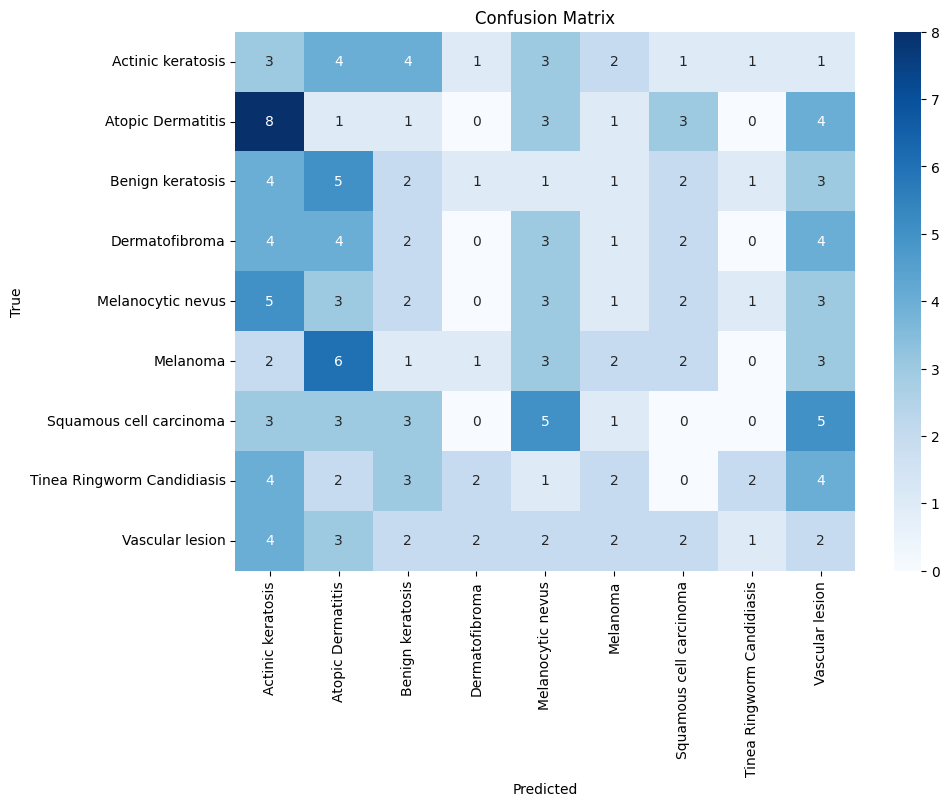

In [ ]:
val_loss, val_accuracy = final_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_val_pred = final_model.predict(val_generator, steps=len(val_generator))
y_val_true = val_generator.classes

cm = confusion_matrix(y_val_true, np.argmax(y_val_pred, axis=1))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

## **Fitting DenseNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


## **Defining DenseNet**

In [ ]:

def create_densenet_model(learning_rate=0.001, dropout_rate=0.5):
    """
    Creates a DenseNet121 model with custom top layers.

    Args:
        learning_rate (float): Learning rate for the Adam optimizer.
        dropout_rate (float): Dropout rate for the dropout layer.

    Returns:
        tf.keras.Model: Compiled DenseNet model.
    """
    base_model = DenseNet121(
        weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model



In [ ]:
def model_train(model, epochs=100, batch_size=32):
    """
    Trains the given model with early stopping.

    Args:
        model (tf.keras.Model): The model to train.
        epochs (int): Maximum number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        float: Best validation accuracy achieved during training.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping],
    )

    return max(history.history['val_accuracy'])


In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [64, 32],
}


In [ ]:

def grid_search():
    """
    Performs a grid search over the hyperparameter space.

    Returns:
        dict: Best hyperparameters found.
        float: Best validation accuracy achieved.
    """
    best_acc = 0
    best_params = {}

    grid = ParameterGrid(param_grid)
    for params in grid:
        print(f"Testing parameters: {params}")
        model = create_densenet_model(
            learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate']
        )
        accuracy = model_train(
            model, batch_size=params['batch_size']
        )
        print(f"Validation Accuracy: {accuracy}")

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params

    return best_params, best_acc


In [ ]:
best_params, best_accuracy = grid_search()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1478 - loss: 2.3294 - val_accuracy: 0.3260 - val_loss: 1.9349
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.2725 - loss: 1.9236 - val_accuracy: 0.4420 - val_loss: 1.6258
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.4101 - loss: 1.6906 - val_accuracy: 0.5249 - val_loss: 1.4189
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - accuracy: 0.5291 - loss: 1.4816 - val_accuracy: 0.5414 - val_loss: 1.2824
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.5712 - loss: 1.2885 - val_accuracy: 0.5746 - val_loss: 1.1969
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.5740 - loss: 1.2444 - val_accuracy: 0.6188 - val_loss: 1.1024
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.6556 - loss: 1.1039 - val_accuracy: 0.6077 - val_loss: 1.0616
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - accuracy: 0.5787 - loss: 1.1357 - val_accuracy: 0

In [ ]:
final_model = create_densenet_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
)

final_model.fit(
    train_generator,
    epochs=100,  # You can adjust the number of epochs
    batch_size=best_params['batch_size'],
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 664ms/step - accuracy: 0.3471 - loss: 1.8632 - val_accuracy: 0.6243 - val_loss: 1.0584
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.6207 - loss: 1.1164 - val_accuracy: 0.6409 - val_loss: 0.8951
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.6414 - loss: 0.9716 - val_accuracy: 0.6740 - val_loss: 0.8217
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.6948 - loss: 0.8185 - val_accuracy: 0.7017 - val_loss: 0.7781
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.7300 - loss: 0.7314 - val_accuracy: 0.7403 - val_loss: 0.7408
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.7128 - loss: 0.7659 - val_accuracy: 0.6906 - val_loss: 0.7580
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.7525 - loss: 0.6418 - val_accuracy: 0.6961 - val_loss: 0.7486
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.7931 - loss: 0.5921 - 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7732 - loss: 0.5910
Validation Accuracy: 0.7901
Validation Loss: 0.5791
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


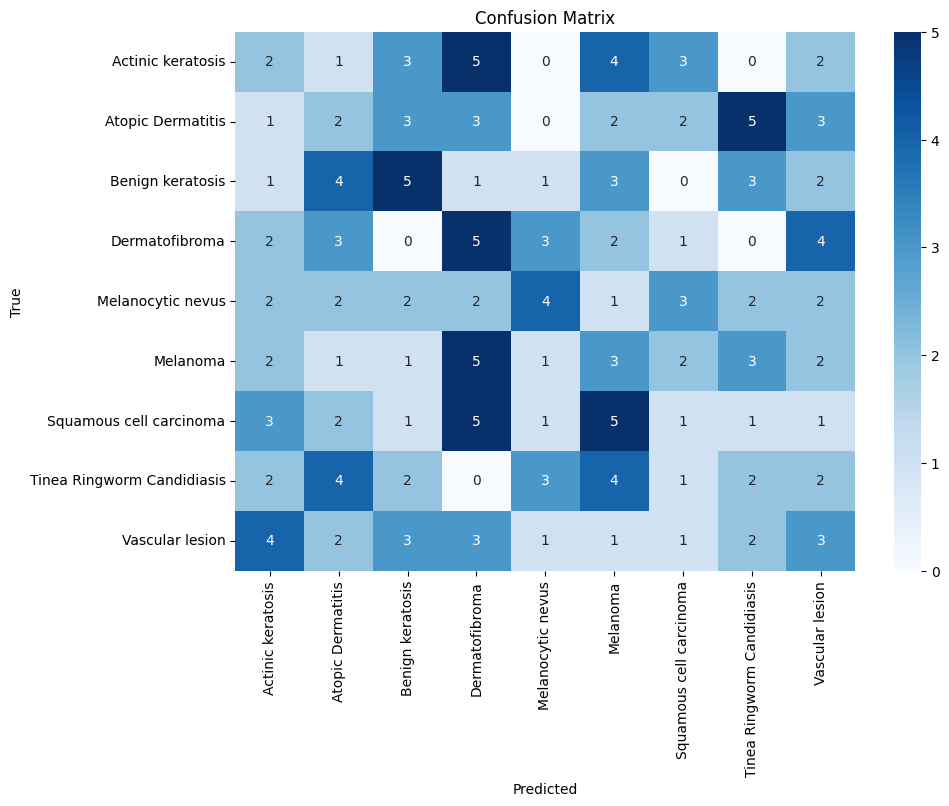

                            precision    recall  f1-score   support

         Actinic keratosis       0.11      0.10      0.10        20
         Atopic Dermatitis       0.10      0.10      0.10        21
          Benign keratosis       0.25      0.25      0.25        20
            Dermatofibroma       0.17      0.25      0.20        20
         Melanocytic nevus       0.29      0.20      0.24        20
                  Melanoma       0.12      0.15      0.13        20
   Squamous cell carcinoma       0.07      0.05      0.06        20
Tinea Ringworm Candidiasis       0.11      0.10      0.11        20
           Vascular lesion       0.14      0.15      0.15        20

                  accuracy                           0.15       181
                 macro avg       0.15      0.15      0.15       181
              weighted avg       0.15      0.15      0.15       181

Training history not found. Cannot plot training/validation metrics.


In [ ]:
from sklearn.metrics import classification_report

val_loss, val_accuracy = final_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_val_pred_prob = final_model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

y_val_true = val_generator.classes

cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=val_generator.class_indices.keys()))

if 'history' in locals() and isinstance(history, History):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()
else:
  print("Training history not found. Cannot plot training/validation metrics.")

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import History


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [17]:
def create_inception_model(learning_rate=0.001, dropout_rate=0.5):
    """
    Creates an InceptionV3 model with custom top layers.

    Args:
        learning_rate (float): Learning rate for the Adam optimizer.
        dropout_rate (float): Dropout rate for the dropout layer.

    Returns:
        tf.keras.Model: Compiled InceptionV3 model.
    """
    base_model = InceptionV3(
        weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model

In [18]:
def model_train(model, epochs=100, batch_size=32):
    """
    Trains the given model with early stopping.

    Args:
        model (tf.keras.Model): The model to train.
        epochs (int): Maximum number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        float: Best validation accuracy achieved during training.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping],
    )

    return max(history.history['val_accuracy']) , history


In [19]:
param_grid = {
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [64, 32],
}


In [20]:
def grid_search():
    """
    Performs a grid search over the hyperparameter space.

    Returns:
        dict: Best hyperparameters found.
        float: Best validation accuracy achieved.
    """
    best_acc = 0
    best_params = {}
    best_history = None

    grid = ParameterGrid(param_grid)
    for params in grid:
        print(f"Testing parameters: {params}")
        model = create_inception_model(
            learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate']
        )
        accuracy, history = model_train(
            model, batch_size=params['batch_size']
        )
        print(f"Validation Accuracy: {accuracy}")

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params
            best_history = history

    return best_params, best_acc, best_history


In [21]:
best_params, best_accuracy, best_history = grid_search()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01}
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 679ms/step - accuracy: 0.2425 - loss: 7.9278 - val_accuracy: 0.5193 - val_loss: 1.3224
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.4822 - loss: 1.4918 - val_accuracy: 0.4862 - val_loss: 1.3795
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.4815 - loss: 1.4210 - val_accuracy: 0.5414 - val_loss: 1.1418
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.4553 - loss: 1.4228 - val_accuracy: 0.5525 - val_loss: 1.1375
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.4620 - loss: 1.4028 - val_accuracy: 0.6022 - val_loss: 1.0856
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.5272 - loss: 1.2316 - val_accuracy: 0.4807 - val_loss: 1.2487
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.4223 - loss: 1.4915 - val_accuracy: 0.5414 - val_loss: 1.1802
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - accuracy: 0.4307 - loss: 1.3818 - val_accuracy

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 629ms/step - accuracy: 0.2557 - loss: 2.2455 - val_accuracy: 0.5691 - val_loss: 1.2930
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.5615 - loss: 1.2797 - val_accuracy: 0.6298 - val_loss: 1.1375
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.6162 - loss: 1.0504 - val_accuracy: 0.6243 - val_loss: 1.0613
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step - accuracy: 0.6323 - loss: 0.9754 - val_accuracy: 0.6906 - val_loss: 0.9411
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.6561 - loss: 0.8889 - val_accuracy: 0.6685 - val_loss: 0.9246
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.6761 - loss: 0.8617 - val_accuracy: 0.7072 - val_loss: 0.8725
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.7038 - loss: 0.7700 - val_accuracy: 0.7017 - val_loss: 0.9235
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.6756 - loss: 0.8694 - 

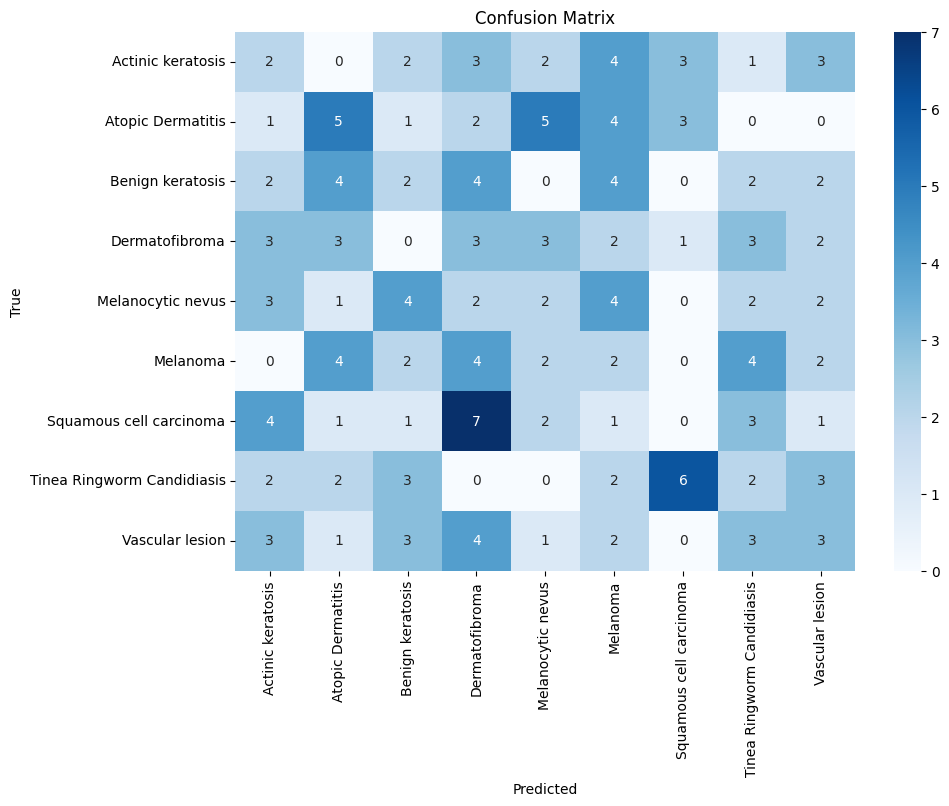

                            precision    recall  f1-score   support

         Actinic keratosis       0.10      0.10      0.10        20
         Atopic Dermatitis       0.24      0.24      0.24        21
          Benign keratosis       0.11      0.10      0.11        20
            Dermatofibroma       0.10      0.15      0.12        20
         Melanocytic nevus       0.12      0.10      0.11        20
                  Melanoma       0.08      0.10      0.09        20
   Squamous cell carcinoma       0.00      0.00      0.00        20
Tinea Ringworm Candidiasis       0.10      0.10      0.10        20
           Vascular lesion       0.17      0.15      0.16        20

                  accuracy                           0.12       181
                 macro avg       0.11      0.12      0.11       181
              weighted avg       0.11      0.12      0.11       181



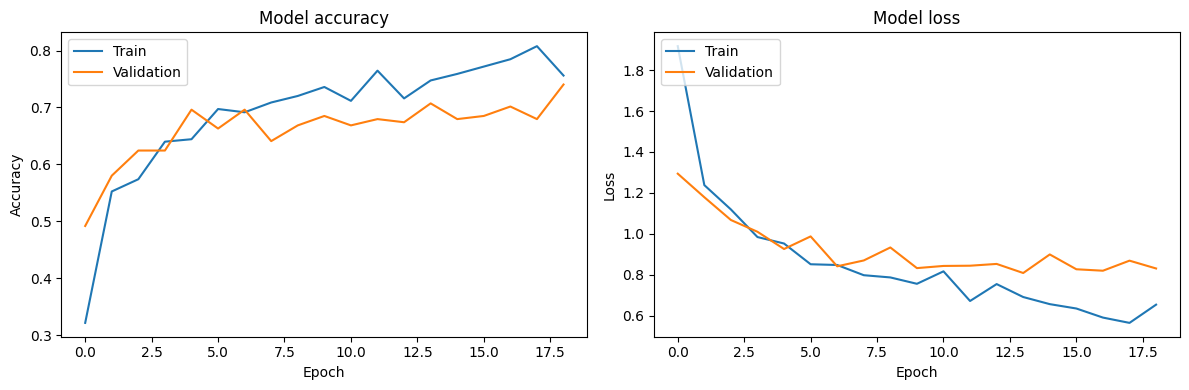

In [22]:

final_model = create_inception_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
)

final_model.fit(
    train_generator,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
)

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

val_loss, val_accuracy = final_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_val_pred_prob = final_model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

y_val_true = val_generator.classes

cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=val_generator.class_indices.keys()))

if best_history:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'])
    plt.plot(best_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
else:
  print("Training history not found. Cannot plot training/validation metrics.")

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=16,
    class_mode='categorical',
)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [25]:
def create_resnet_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = ResNet50(
        weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model

In [26]:
def model_train(model, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping],
    )
    return max(history.history['val_accuracy']), history

In [33]:
param_grid = {
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [64, 32],
}

In [34]:
def grid_search():
    best_acc = 0
    best_params = {}
    best_history = None

    grid = ParameterGrid(param_grid)
    for params in grid:
        print(f"Testing parameters: {params}")
        model = create_resnet_model(
            learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate']
        )
        accuracy, history = model_train(
            model, batch_size=params['batch_size']
        )
        print(f"Validation Accuracy: {accuracy}")

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params
            best_history = history

    return best_params, best_acc, best_history

In [35]:
best_params, best_accuracy, best_history = grid_search()
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

final_model = create_resnet_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
)
final_model.fit(
    train_generator,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
)

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - accuracy: 0.1172 - loss: 3.2817 - val_accuracy: 0.1105 - val_loss: 2.1975
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - accuracy: 0.1186 - loss: 2.1942 - val_accuracy: 0.1105 - val_loss: 2.1987
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.1283 - loss: 2.1924 - val_accuracy: 0.1105 - val_loss: 2.2000
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.1142 - loss: 2.1920 - val_accuracy: 0.1105 - val_loss: 2.2008
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.0866 - loss: 2.1932 - val_accuracy: 0.1160 - val_loss: 2.2016
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.1108 - loss: 2.1921 - val_accuracy: 0.1160 - val_loss: 2.2026
Validation Accuracy: 0.11602210253477097
Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Epoch 1/100


KeyboardInterrupt: 

In [ ]:
val_loss, val_accuracy = final_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_val_pred_prob = final_model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = val_generator.classes

cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=val_generator.class_indices.keys()))

In [5]:
!pip install efficientnet tensorflow==2.13.0

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # You can choose other variants like B1, B2, etc.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def create_efficientnet_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = EfficientNetB0(
        weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False  # Freeze base model layers for initial training
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model

In [18]:
def model_train(model, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )
    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_generator,
        callbacks=[early_stopping],
    )
    return max(history.history['val_accuracy']), history

In [19]:
param_grid = {
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [64, 32],
}

In [20]:
def grid_search():
    best_acc = 0
    best_params = {}
    best_history = None
    grid = ParameterGrid(param_grid)
    for params in grid:
        print(f"Testing parameters: {params}")
        model = create_efficientnet_model(
            learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate']
        )
        accuracy, history = model_train(
            model, batch_size=params['batch_size']
        )
        print(f"Validation Accuracy: {accuracy}")
        if accuracy > best_acc:
            best_acc = accuracy
            best_params = params
            best_history = history
    return best_params, best_acc, best_history

In [21]:
best_params, best_accuracy, best_history = grid_search()
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

final_model = create_efficientnet_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
)
final_model.fit(
    train_generator,
    epochs=100,  # You can adjust the number of epochs
    batch_size=best_params['batch_size'],
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
)

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1/100
44/44 [==============================] - 74s 1s/step - loss: 2.6267 - accuracy: 0.1320 - val_loss: 2.1974 - val_accuracy: 0.1105
Epoch 2/100
44/44 [==============================] - 58s 1s/step - loss: 2.1984 - accuracy: 0.1105 - val_loss: 2.1988 - val_accuracy: 0.1105
Epoch 3/100
44/44 [==============================] - 57s 1s/step - loss: 2.1952 - accuracy: 0.0904 - val_loss: 2.1999 - val_accuracy: 0.1105
Epoch 4/100
44/44 [==============================] - 56s 1s/step - loss: 2.1985 - accuracy: 0.0904 - val_loss: 2.2008 - val_accuracy: 0.1105
Epoch 5/100
44/44 [==============================] - 57s 1s/step - loss: 2.1943 - accuracy: 0.1133 - val_loss: 2.2025 - val_accuracy: 0.1105
Epoch 6/100
44/44 [==============================] - 58s 1s/step - loss: 2.1972 - accuracy: 0.1019 - val_loss: 2.2023 - val_accuracy: 0.1105
Validation Accuracy: 0.11049723625183105
Testing parameters: {'batch_si

KeyboardInterrupt: 

In [ ]:
val_loss, val_accuracy = final_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_val_pred_prob = final_model.predict(val_generator)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

y_val_true = val_generator.classes

cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=val_generator.class_indices.keys()))